In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [3]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


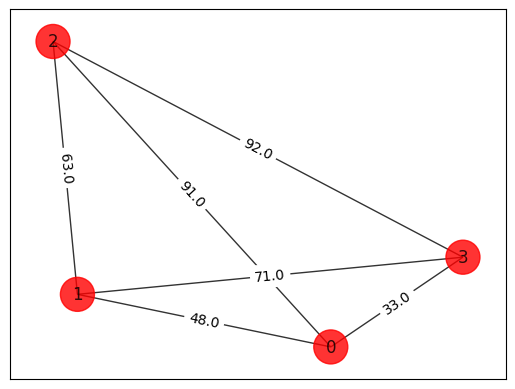

In [4]:
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


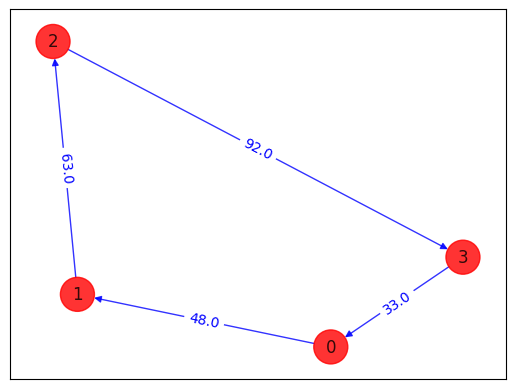

In [5]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [6]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [7]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

In [8]:
result = CplexOptimizer().solve(qp)
print(result.prettyprint())

objective function value: 236.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=1.0
status: SUCCESS


In [9]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [10]:
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0
)

In [11]:
import time

In [12]:
start = time.time()
ws_result = ws_qaoa.solve(qp)
end = time.time()
print(ws_result.prettyprint())
print(f"Time to solve: {end - start}")

objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
Time to solve: 237.07871866226196


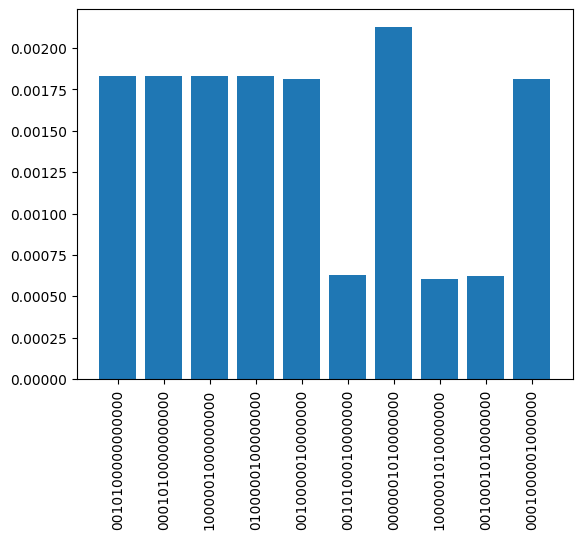

In [24]:
def samples_to_graph(data):
    data_val={}
    data_prob={}
    for i in data:
        arr=i.x.tolist()
        arr=[str(int(i)) for i in arr]
        key=''.join(arr)
        data_val[key]=i.fval
        data_prob[key]=i.probability
    data_val_sorted=sorted(data_val, key=data_val.get)
    least_10=data_val_sorted[0:10]
    plot_dic={}
    for i in least_10:
        plot_dic[i]=data_prob[i]
    plt.xticks(rotation=90)
    plt.bar(range(len(plot_dic)), plot_dic.values(), tick_label=least_10)
    
    return least_10[0], plot_dic

optimal_10_warm_start, optimal_10_prob_warm_start = samples_to_graph(ws_result.samples)

In [13]:
print(ws_result.raw_samples)

[SolutionSample(x=array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]), fval=236.0, probability=7.34969928452e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]), fval=236.0, probability=7.34969925468e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]), fval=236.0, probability=7.34969817508e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), fval=236.0, probability=7.34969875756e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]), fval=236.0, probability=7.34969821575e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), fval=236.0, probability=7.34969818591e-05, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(

solution: [3, 2, 1, 0]
solution objective: 236.0


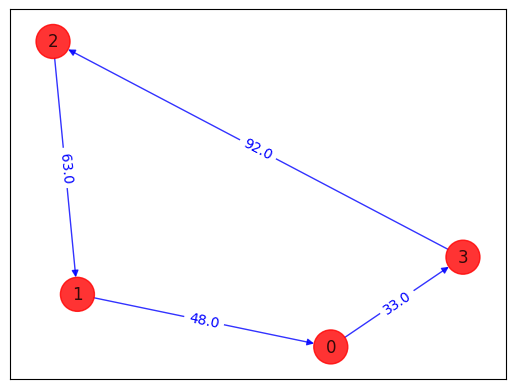

In [14]:
# x = tsp.sample_most_likely(ws_result.min_eigen_solver_result)
# x = tsp.sample_most_likely(ws_qaoa)
# print("feasible:", qp.is_feasible(ws_result))
z = tsp.interpret(ws_result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [15]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))

    # res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
    res = qaoa_res

    return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]
format_qaoa_samples(ws_result.samples)

['0001001001001000: value: 236.000, probability: 0.0%',
 '0100001000011000: value: 236.000, probability: 0.0%',
 '0010000110000100: value: 236.000, probability: 0.0%',
 '1000000100100100: value: 236.000, probability: 0.0%',
 '0001100001000010: value: 236.000, probability: 0.0%',
 '0100100000010010: value: 236.000, probability: 0.0%',
 '0010010010000001: value: 236.000, probability: 0.0%',
 '1000010000100001: value: 236.000, probability: 0.0%',
 '0001010000101000: value: 258.000, probability: 0.0%',
 '0100000100101000: value: 258.000, probability: 0.0%',
 '0010100000010100: value: 258.000, probability: 0.0%',
 '1000001000010100: value: 258.000, probability: 0.0%',
 '0001010010000010: value: 258.000, probability: 0.0%',
 '0100000110000010: value: 258.000, probability: 0.0%',
 '0010100001000001: value: 258.000, probability: 0.0%',
 '1000001001000001: value: 258.000, probability: 0.0%',
 '0010000101001000: value: 302.000, probability: 0.0%',
 '0010010000011000: value: 302.000, probability:

In [16]:
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()

In [17]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [18]:
start = time.time()
qaoa_result = qaoa.solve(qp)
end = time.time()
print(f"Time to solve: {end-start} seconds")
print(qaoa_result.prettyprint())

Time to solve: 374.1584846973419 seconds
objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


In [19]:
format_qaoa_samples(qaoa_result.samples)

['0001001001001000: value: 236.000, probability: 0.0%',
 '0100001000011000: value: 236.000, probability: 0.0%',
 '0010000110000100: value: 236.000, probability: 0.0%',
 '1000000100100100: value: 236.000, probability: 0.0%',
 '0001100001000010: value: 236.000, probability: 0.0%',
 '0100100000010010: value: 236.000, probability: 0.0%',
 '0010010010000001: value: 236.000, probability: 0.0%',
 '1000010000100001: value: 236.000, probability: 0.0%',
 '0001010000101000: value: 258.000, probability: 0.0%',
 '0100000100101000: value: 258.000, probability: 0.0%',
 '0010100000010100: value: 258.000, probability: 0.0%',
 '1000001000010100: value: 258.000, probability: 0.0%',
 '0001010010000010: value: 258.000, probability: 0.0%',
 '0100000110000010: value: 258.000, probability: 0.0%',
 '0010100001000001: value: 258.000, probability: 0.0%',
 '1000001001000001: value: 258.000, probability: 0.0%',
 '0010000101001000: value: 302.000, probability: 0.0%',
 '0010010000011000: value: 302.000, probability:

solution: [3, 2, 1, 0]
solution objective: 236.0


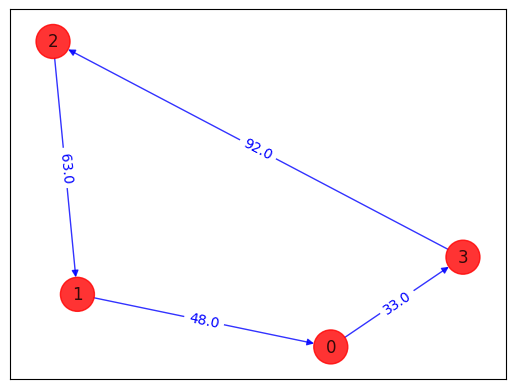

In [20]:
z = tsp.interpret(qaoa_result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)